In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from tabulate import tabulate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import scipy.stats as stats



In [28]:
def load_and_clean_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
    # Fill missing values in 'quantity_sold' using forward fill and backward fill
    data['quantity_sold'] = data['quantity_sold'].fillna(method='ffill').fillna(method='bfill')
    return data


In [29]:
def feature_engineering(data):
    # Create a complete date range without gaps
    date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')
    complete_data = pd.DataFrame({'date': date_range})
    data = pd.merge(complete_data, data, on='date', how='left')
    
    # Fill missing values in categorical columns
    if 'brand' in data.columns:
        data['brand'].fillna(method='ffill', inplace=True)
    if 'model' in data.columns:
        data['model'].fillna(method='ffill', inplace=True)
    
    # Basic time features
    data['day_of_year'] = data['date'].dt.dayofyear
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Holiday features (expanded list)
    holidays = pd.to_datetime([
        '2024-01-01',  # New Year's Day
        '2024-01-26',  # Republic Day
        '2024-08-15',  # Independence Day
        '2024-10-02',  # Gandhi Jayanti
        '2024-12-25'   # Christmas
    ])
    data['is_holiday'] = data['date'].isin(holidays).astype(int)
    
    # Handle missing values in quantity_sold using linear interpolation
    data['quantity_sold'] = data['quantity_sold'].fillna(method='ffill').fillna(method='bfill')
    data['quantity_sold'] = data['quantity_sold'].interpolate(method='linear')
    
    # Advanced features
    data['rolling_mean_7d'] = data['quantity_sold'].rolling(window=7, min_periods=1, center=True).mean()
    data['rolling_mean_30d'] = data['quantity_sold'].rolling(window=30, min_periods=1, center=True).mean()
    data['rolling_std_7d'] = data['quantity_sold'].rolling(window=7, min_periods=1, center=True).std()
    data['rolling_std_30d'] = data['quantity_sold'].rolling(window=30, min_periods=1, center=True).std()
    
    # Trend features
    data['trend'] = np.arange(len(data))
    data['trend_normalized'] = (data['trend'] - data['trend'].mean()) / data['trend'].std()
    
    # Seasonal features
    data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
    data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_year']/365)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_year']/365)
    
    # Lag features
    for lag in [1, 3, 7, 14, 30]:
        data[f'lag_{lag}'] = data['quantity_sold'].shift(lag)
        data[f'lag_{lag}'].fillna(data['rolling_mean_7d'], inplace=True)
    
    return data

In [30]:
def sales_prediction(data, forecast_days=7, brand=None, model=None):
    filtered = data.copy()
    if brand:
        filtered = filtered[filtered['brand'] == brand]
    if model:
        filtered = filtered[filtered['model'] == model]

    if filtered.empty:
        print("No data available for the specified brand and model.")
        return pd.DataFrame()

    # Feature engineering
    filtered = feature_engineering(filtered)
    
    feature_cols = [
        'day_of_year', 'month', 'day_of_week', 'is_weekend', 'is_holiday',
        'rolling_mean_7d', 'rolling_mean_30d', 'rolling_std_7d', 'rolling_std_30d',
        'trend_normalized', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
        'lag_1', 'lag_3', 'lag_7', 'lag_14', 'lag_30'
    ]
    
    X = filtered[feature_cols]
    y = filtered['quantity_sold']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train model
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42
    )

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_scaled, y, cv=tscv)
    
    # Print cross-validation results in table format
    cv_table = [["Split " + str(i+1), score] for i, score in enumerate(cv_scores)]
    print("\nCross-validation Scores:")
    print(tabulate(cv_table, headers=["Split", "Score"], tablefmt="grid"))
    print(f"Mean CV Score: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")

    # Fit model
    model.fit(X_scaled, y)

    # Prepare future data
    last_date = filtered['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=forecast_days, freq='D')
    
    future_data = pd.DataFrame({'date': future_dates})
    future_data = feature_engineering(pd.concat([filtered, future_data], axis=0)).tail(forecast_days)
    
    X_future = future_data[feature_cols]
    X_future_scaled = scaler.transform(X_future)
    
    # Make predictions
    predictions = model.predict(X_future_scaled)
    smoothed_predictions = gaussian_filter1d(predictions, sigma=0.8)
    
    # Create forecast DataFrame
    forecast = pd.DataFrame({
        'date': future_dates,
        'predicted_sales': smoothed_predictions
    })

    # Print forecast in table format
    print("\nSales Forecast:")
    print(tabulate(forecast, headers='keys', tablefmt="grid", showindex=False))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.style.use('default')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot historical data
    plt.plot(filtered['date'], filtered['quantity_sold'], 
             label='Historical Sales', color='#2E86C1', linewidth=2, alpha=0.8)
    
    # Plot forecast
    plt.plot(forecast['date'], forecast['predicted_sales'], 
             label='Forecasted Sales', color='#E74C3C', linewidth=2.5, 
             linestyle='--', marker='o', markersize=6)
    
    # Add confidence interval
    std_dev = filtered['quantity_sold'].std()
    plt.fill_between(forecast['date'],
                    forecast['predicted_sales'] - 1.96 * std_dev,
                    forecast['predicted_sales'] + 1.96 * std_dev,
                    color='#E74C3C', alpha=0.2)
    
    plt.title('Sales Forecast with Confidence Interval', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.xticks(rotation=45)
    
    # Add annotations
    last_actual = filtered['quantity_sold'].iloc[-1]
    first_predicted = forecast['predicted_sales'].iloc[0]
    plt.annotate(f'Last Actual: {last_actual:.1f}',
                xy=(filtered['date'].iloc[-1], last_actual),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'First Predicted: {first_predicted:.1f}',
                xy=(forecast['date'].iloc[0], first_predicted),
                xytext=(10, -15), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

    return forecast


In [31]:
def demand_analysis(data, brand, model):
    filtered = data[(data['brand'] == brand) & (data['model'] == model)].copy()
    
    if filtered.empty:
        print("No data available for the specified brand and model.")
        return

    # Calculate statistics
    stats_dict = {
        'Average Sales': filtered['quantity_sold'].mean(),
        'Median Sales': filtered['quantity_sold'].median(),
        'Maximum Sales': filtered['quantity_sold'].max(),
        'Minimum Sales': filtered['quantity_sold'].min(),
        'Standard Deviation': filtered['quantity_sold'].std(),
        'Total Sales': filtered['quantity_sold'].sum()
    }
    
    # Print statistics in table format
    stats_table = [[k, f"{v:.2f}"] for k, v in stats_dict.items()]
    print("\nDemand Analysis Statistics:")
    print(tabulate(stats_table, headers=["Metric", "Value"], tablefmt="grid"))

    # Calculate moving averages
    filtered['MA7'] = filtered['quantity_sold'].rolling(window=7, center=True).mean()
    filtered['MA30'] = filtered['quantity_sold'].rolling(window=30, center=True).mean()
    
    # Print moving averages in table format
    ma_data = filtered[['date', 'quantity_sold', 'MA7', 'MA30']].tail(10)
    print("\nRecent Moving Averages (Last 10 days):")
    print(tabulate(ma_data, headers=['Date', 'Sales', '7-day MA', '30-day MA'], 
                  tablefmt="grid", showindex=False, floatfmt=".2f"))

    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Sales time series
    plt.subplot(2, 1, 1)
    plt.plot(filtered['date'], filtered['quantity_sold'], 
             label='Daily Sales', color='#2E86C1', alpha=0.6)
    plt.plot(filtered['date'], filtered['MA7'], 
             label='7-day Moving Average', color='#E74C3C', linewidth=2)
    plt.plot(filtered['date'], filtered['MA30'], 
             label='30-day Moving Average', color='#27AE60', linewidth=2)
    
    plt.title(f'Demand Analysis for {brand} {model}', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Quantity Sold', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Sales distribution
    plt.subplot(2, 1, 2)
    n, bins, patches = plt.hist(filtered['quantity_sold'], bins=30, 
                              color='#2E86C1', alpha=0.7, density=True)
    
    density = stats.gaussian_kde(filtered['quantity_sold'])
    plt.plot(bins, density(bins), color='#E74C3C', linewidth=2, 
             label='Density Estimate')
    
    plt.axvline(stats_dict['Average Sales'], color='#27AE60', linestyle='--', 
                label=f'Mean: {stats_dict["Average Sales"]:.1f}')
    plt.axvline(stats_dict['Median Sales'], color='#F39C12', linestyle='--', 
                label=f'Median: {stats_dict["Median Sales"]:.1f}')
    
    plt.title('Sales Distribution', fontsize=14)
    plt.xlabel('Quantity Sold', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [32]:
def stockout_prediction(data, brand, model, current_stock, reorder_threshold, lead_time):
    filtered = data[(data['brand'] == brand) & (data['model'] == model)].copy()
    
    if filtered.empty:
        print("No data available for the specified brand and model.")
        return

    # Calculate metrics
    avg_daily_sales = filtered['quantity_sold'].mean()
    std_daily_sales = filtered['quantity_sold'].std()
    max_daily_sales = filtered['quantity_sold'].max()
    safety_stock = 2 * std_daily_sales * np.sqrt(lead_time)
    reorder_point = (avg_daily_sales * lead_time) + safety_stock
    
    # Calculate days until stockout
    avg_case_days = current_stock / avg_daily_sales if avg_daily_sales > 0 else float('inf')
    worst_case_days = current_stock / max_daily_sales if max_daily_sales > 0 else float('inf')
    
    # Print metrics in table format
    metrics_table = [
        ["Current Stock", current_stock],
        ["Average Daily Sales", f"{avg_daily_sales:.2f}"],
        ["Maximum Daily Sales", max_daily_sales],
        ["Safety Stock", f"{safety_stock:.2f}"],
        ["Reorder Point", f"{reorder_point:.2f}"],
        ["Days until Stockout (Avg Case)", f"{avg_case_days:.1f}"],
        ["Days until Stockout (Worst Case)", f"{worst_case_days:.1f}"]
    ]
    print("\nStock Analysis Metrics:")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

    # Generate stock projections
    days = np.arange(0, int(max(avg_case_days, worst_case_days) * 1.5))
    projections = pd.DataFrame({
        'Day': days,
        'Average Case': current_stock - (avg_daily_sales * days),
        'Worst Case': current_stock - (max_daily_sales * days)
    })
    
    # Print projections in table format
    print("\nStock Level Projections (First 10 days):")
    print(tabulate(projections.head(10), headers='keys', tablefmt="grid", showindex=False))

    # Plotting
    plt.figure(figsize=(12, 6))
    
    plt.axhline(y=current_stock, color='#2E86C1', linestyle='-', 
                label='Current Stock', linewidth=2)
    plt.axhline(y=reorder_point, color='#E74C3C', linestyle='--', 
                label='Reorder Point', linewidth=2)
    plt.axhline(y=safety_stock, color='#F39C12', linestyle=':', 
                label='Safety Stock', linewidth=2)
    
    plt.plot(days, projections['Average Case'], color='#27AE60', 
             label='Average Case Projection', linewidth=2)
    plt.plot(days, projections['Worst Case'], color='#8E44AD', 
             label='Worst Case Projection', linewidth=2)
    
    plt.title(f'Stock Level Projection for {brand} {model}', fontsize=14, pad=20)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Stock Level', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.annotate(f'Current Stock: {current_stock}', 
                xy=(0, current_stock), xytext=(5, 5),
                textcoords='offset points')
    plt.annotate(f'Reorder Point: {reorder_point:.1f}', 
                xy=(0, reorder_point), xytext=(5, 5),
                textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

    # Print recommendations
    print("\nRecommendations:")
    if current_stock <= reorder_point:
        print(f"⚠️ ALERT: Stock level ({current_stock}) is at or below reorder point ({reorder_point:.1f})")
        print(f"Action Required: Place order within {lead_time} days to avoid stockout")
    else:
        days_until_reorder = (current_stock - reorder_point) / avg_daily_sales
        print(f"✓ Stock level is adequate")
        print(f"Next reorder in approximately {days_until_reorder:.1f} days")


In [33]:
# Step 1: Load and clean data
data = load_and_clean_data('sales_data_2021_2024.csv')

# Step 2: Feature Engineering
data = feature_engineering(data)






C:\Users\91935\AppData\Local\Temp\ipykernel_18532\421232357.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\421232357.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['quantity_sold'] = data['quantity_sold'].fillna(method='ffill').fillna(method='bfill')
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['brand'].fillna(method='ffill', inplace=True)
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['brand'].fillna(method='ffill', inplace=True)
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:11: FutureWarning: A value is trying to be set on a


Cross-validation Scores:
+---------+----------+
| Split   |    Score |
+=========+==========+
| Split 1 | 0.146729 |
+---------+----------+
| Split 2 | 0.170019 |
+---------+----------+
| Split 3 | 0.1752   |
+---------+----------+
| Split 4 | 0.187925 |
+---------+----------+
| Split 5 | 0.1518   |
+---------+----------+
Mean CV Score: 0.166 (±0.030)


C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['brand'].fillna(method='ffill', inplace=True)
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['brand'].fillna(method='ffill', inplace=True)
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\3837430023.py:11: FutureWarning: A value is trying to be set on a


Sales Forecast:
+---------------------+-------------------+
| date                |   predicted_sales |
+=====================+===================+
| 2025-01-01 00:00:00 |           38.0147 |
+---------------------+-------------------+
| 2025-01-02 00:00:00 |           37.8287 |
+---------------------+-------------------+
| 2025-01-03 00:00:00 |           37.3883 |
+---------------------+-------------------+
| 2025-01-04 00:00:00 |           37.2084 |
+---------------------+-------------------+
| 2025-01-05 00:00:00 |           37.192  |
+---------------------+-------------------+
| 2025-01-06 00:00:00 |           37.1286 |
+---------------------+-------------------+
| 2025-01-07 00:00:00 |           37.018  |
+---------------------+-------------------+


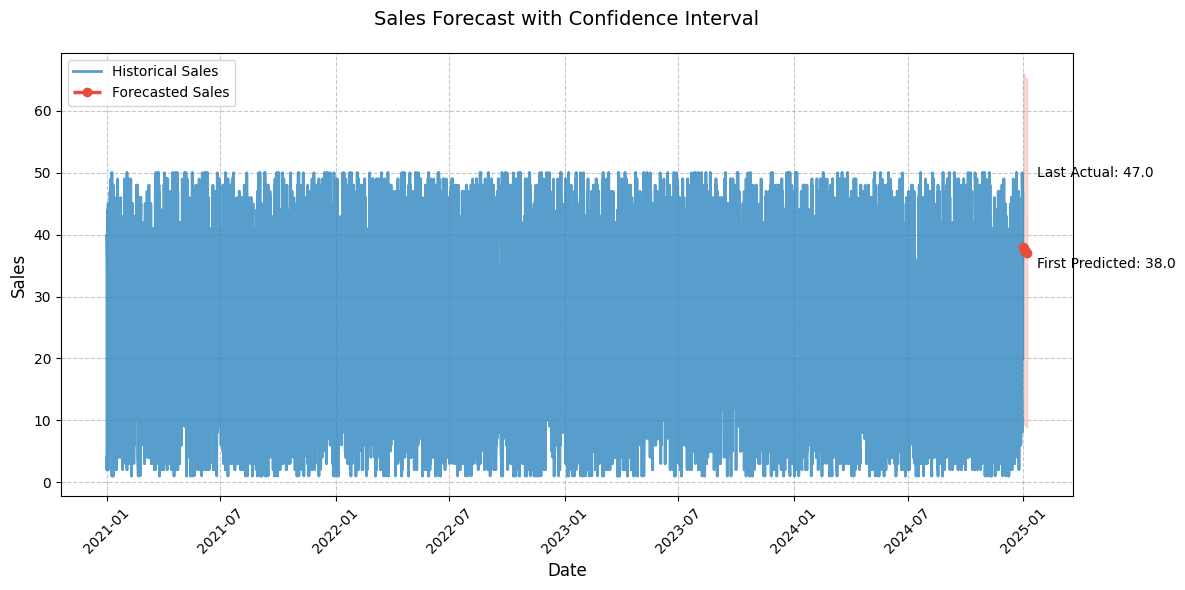

,date,predicted_sales
0,2025-01-01,38.014723
1,2025-01-02,37.828671
2,2025-01-03,37.388285
3,2025-01-04,37.208450
4,2025-01-05,37.192040
5,2025-01-06,37.128644
6,2025-01-07,37.017954


In [34]:
# Step 3: Sales Prediction using Random Forest
sales_prediction(data)


Demand Analysis Statistics:
+--------------------+---------+
| Metric             |   Value |
+====================+=========+
| Average Sales      |   22.11 |
+--------------------+---------+
| Median Sales       |   19.5  |
+--------------------+---------+
| Maximum Sales      |   50    |
+--------------------+---------+
| Minimum Sales      |    1    |
+--------------------+---------+
| Standard Deviation |   14.11 |
+--------------------+---------+
| Total Sales        | 3360    |
+--------------------+---------+

Recent Moving Averages (Last 10 days):
+---------------------+---------+------------+-------------+
| Date                |   Sales |   7-day MA |   30-day MA |
+=====================+=========+============+=============+
| 2024-09-27 00:00:00 |    3.00 |      25.57 |         nan |
+---------------------+---------+------------+-------------+
| 2024-09-28 00:00:00 |    6.00 |      23.86 |         nan |
+---------------------+---------+------------+-------------+
| 2024-09

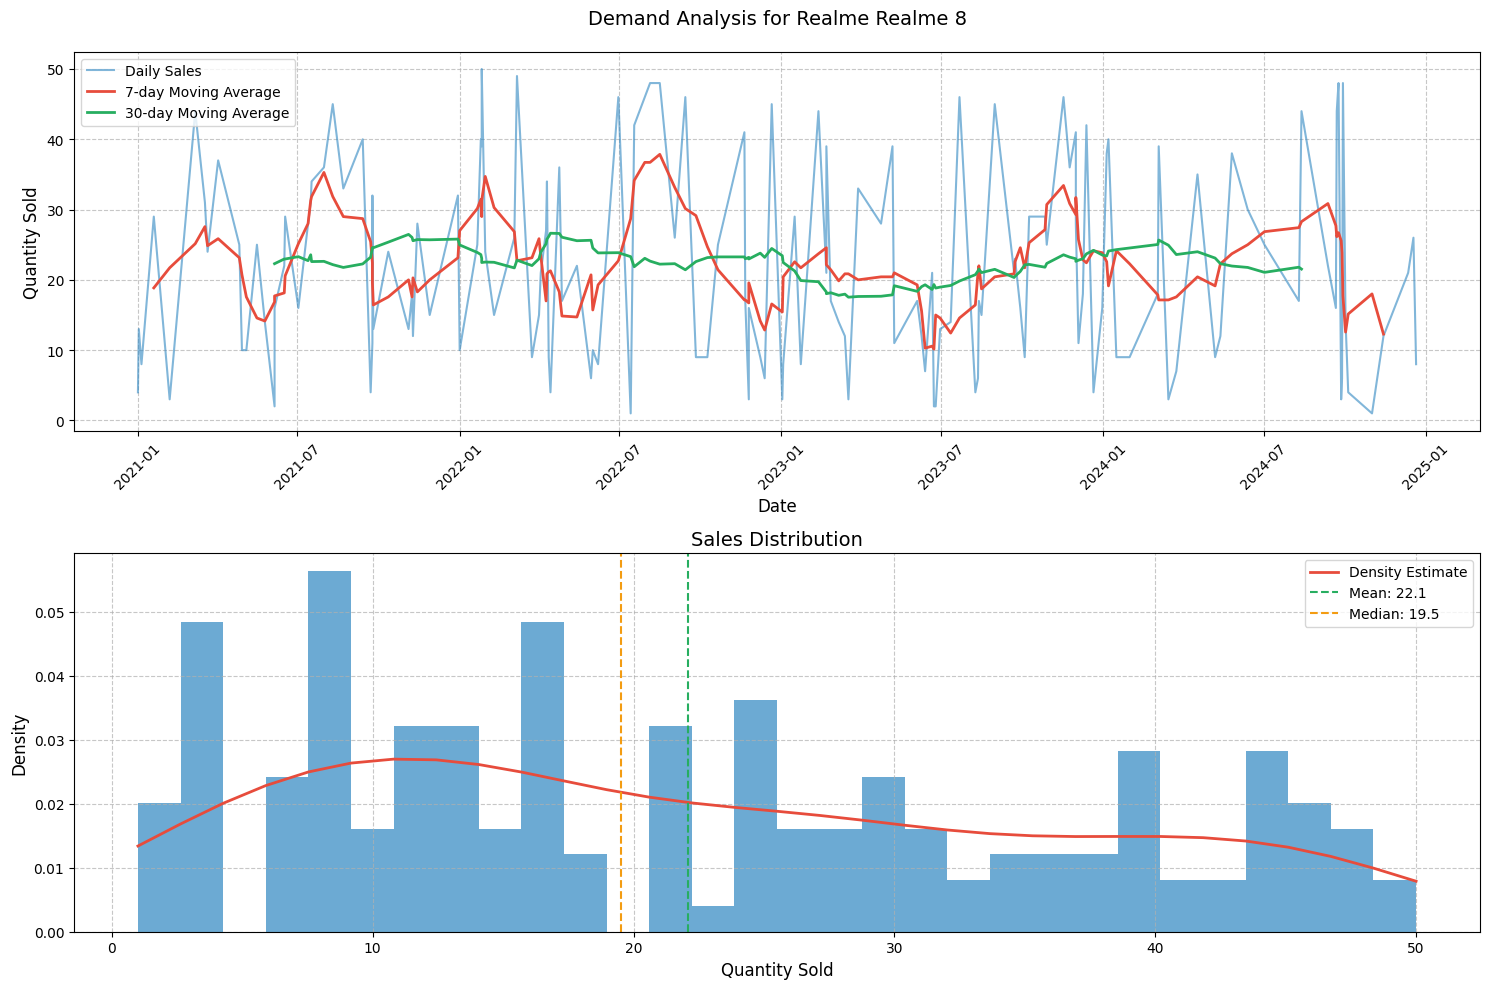

In [37]:
brands = data['brand'].unique()
models = data['model'].unique()

# Example of using the first brand and model in the list
brand = brands[0]
model = models[0]

# Call the demand analysis function
demand_analysis(data, brand, model)

C:\Users\91935\AppData\Local\Temp\ipykernel_18532\2859405410.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_stock = data[data['brand'] == brand][data['model'] == model]['current_stock'].iloc[0]
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\2859405410.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reorder_threshold = data[data['brand'] == brand][data['model'] == model]['reorder_threshold'].iloc[0]
C:\Users\91935\AppData\Local\Temp\ipykernel_18532\2859405410.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lead_time = data[data['brand'] == brand][data['model'] == model]['lead_time'].iloc[0]



Stock Analysis Metrics:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Current Stock                    |  480    |
+----------------------------------+---------+
| Average Daily Sales              |   22.11 |
+----------------------------------+---------+
| Maximum Daily Sales              |   50    |
+----------------------------------+---------+
| Safety Stock                     |   48.87 |
+----------------------------------+---------+
| Reorder Point                    |  115.18 |
+----------------------------------+---------+
| Days until Stockout (Avg Case)   |   21.7  |
+----------------------------------+---------+
| Days until Stockout (Worst Case) |    9.6  |
+----------------------------------+---------+

Stock Level Projections (First 10 days):
+-------+----------------+--------------+
|   Day |   Average Case |   Worst Case |
+=======+================+==============+
|     0 

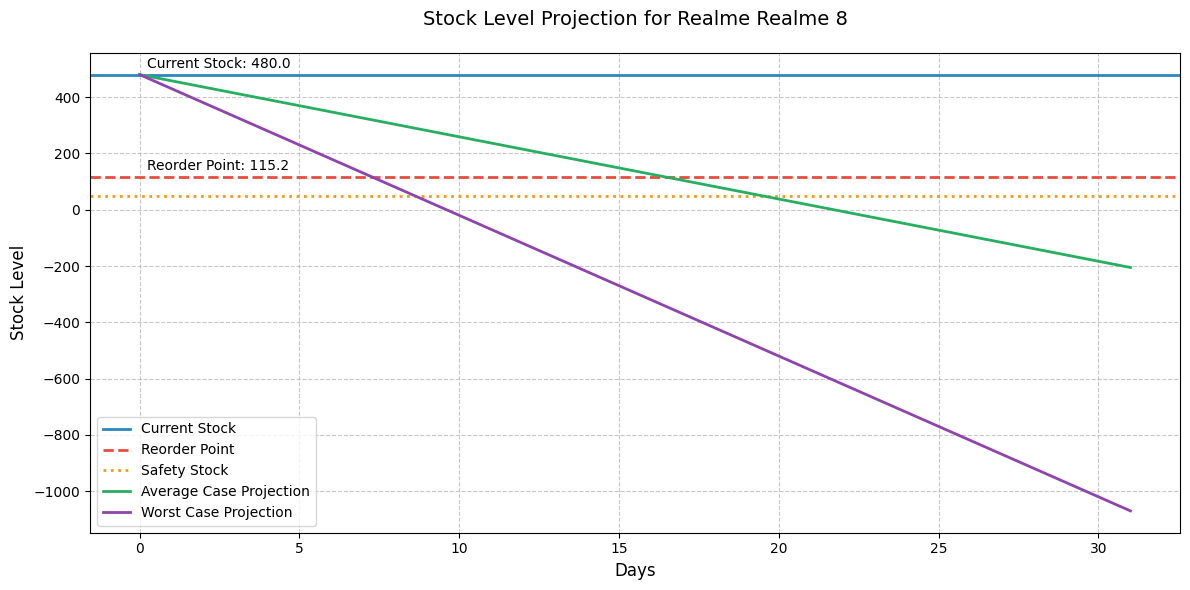


Recommendations:
✓ Stock level is adequate
Next reorder in approximately 16.5 days


In [38]:
# Extract current stock, reorder threshold, and lead time from the data
current_stock = data[data['brand'] == brand][data['model'] == model]['current_stock'].iloc[0]
reorder_threshold = data[data['brand'] == brand][data['model'] == model]['reorder_threshold'].iloc[0]
lead_time = data[data['brand'] == brand][data['model'] == model]['lead_time'].iloc[0]

# Call the stockout prediction function with extracted values
stockout_prediction(data, brand, model, current_stock, reorder_threshold, lead_time)
